In [1]:
#tensorboard via command-line:
#tensorboard --logdir=where your Logs directory is

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#Predict whether or not a flare will occur in the next 24hrs after a 24hr time sequence, per monitored AR.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#feature data from - hmi.sharp_720s:::
#http://jsoc.stanford.edu/doc/data/hmi/sharp/sharp.htm

#label data from - GOES flare events:::
#ftp://ftp.swpc.noaa.gov/pub/warehouse/

#and from - GOES XRS Report:::
#https://www.ngdc.noaa.gov/stp/space-weather/solar-data/solar-features/solar-flares/x-rays/goes/xrs/
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#binary class - F for flare and N for no flare
#multi-class - #6 flare classes: N is no flare, A is smallest, X is largest
               #key = {'N', 'A', 'B', 'C', 'M', 'X'}
               #['A' class flares generally not listed in official reports due to small size]
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

In [3]:
import tensorflow as tf
print("tensorflow version:", tf.__version__) #2.3.1 used
from tensorflow import keras
import os
import glob
import shutil
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from astropy.time import Time
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dropout, Dense, Embedding, Flatten, SimpleRNN, LSTM, GRU, GaussianNoise
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import drms #https://pypi.org/project/drms/
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
import Flare_Data
import Feature_Years
import Make_TB_Logs
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

tensorflow version: 2.3.1


In [4]:
Feature_Years.generate_all_feature_years()

CSVs compiled.


In [5]:
where_logs = Make_TB_Logs.make_clear_tensorboard_folder()

In [6]:
#binary = True for binary classification, binary = False for multi-class classification
X_train, X_val, X_test, y_train, y_val, y_test, tim_steps, n_feats, count_of_classes, a_encoder = Flare_Data.getAllData(binary = True)

The time series starts from:  2011-01-01 00:11:26
The time series ends on:  2016-12-31 23:47:24
(array(['F', 'N'], dtype='<U1'), array([741, 729], dtype=int64))


In [7]:
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(940, 114, 20) (236, 114, 20) (294, 114, 20) (940, 1) (236, 1) (294, 1)


In [8]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

In [9]:
batch_size = 50
epochs = 100
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-06, decay=0.0)
#optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-06, decay=0.0)

In [10]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~[GRU_1 Model]~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~[Binary-Class]~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~[Single Layer]~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
model = Sequential()
model.add(GRU(19,  input_shape=(tim_steps, n_feats), recurrent_dropout=0.05))
model.add(GaussianNoise(0.01))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['binary_accuracy'])
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

In [11]:
tensorboard_call = keras.callbacks.TensorBoard(log_dir=where_logs, histogram_freq=1)
#val_loss_callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=100)

In [12]:
history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=(X_val, y_val), 
                    verbose=1, 
                    callbacks=[tensorboard_call]) #, val_loss_callback])

Epoch 1/100
 1/19 [>.............................] - ETA: 0s - loss: 0.7238 - binary_accuracy: 0.5000WARNING:tensorflow:From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
19/19 [==============================] - 2s 93ms/step - loss: 0.7012 - binary_accuracy: 0.5064 - val_loss: 0.7030 - val_binary_accuracy: 0.4746
Epoch 2/100
19/19 [==============================] - 1s 50ms/step - loss: 0.6907 - binary_accuracy: 0.5128 - val_loss: 0.7020 - val_binary_accuracy: 0.4534
Epoch 3/100
19/19 [==============================] - 1s 53ms/step - loss: 0.6881 - binary_accuracy: 0.5287 - val_loss: 0.7024 - val_binary_accuracy: 0.4534
Epoch 4/100
19/19 [==============================] - 1s 49ms/step - loss: 0.6861 - binary_accuracy: 0.5532 - val_loss: 0.7035 - val_binary_accuracy: 0.4661
Epoch

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 19)                2337      
_________________________________________________________________
gaussian_noise (GaussianNois (None, 19)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 20        
Total params: 2,357
Trainable params: 2,357
Non-trainable params: 0
_________________________________________________________________


In [14]:
#evaluate model on test set
results = model.evaluate(X_test, y_test, batch_size=1, verbose=1)
print("test loss, test acc:", results)

294/294 [==============================] - 2s 7ms/step - loss: 0.6404 - binary_accuracy: 0.6531
test loss, test acc: [0.6404228210449219, 0.6530612111091614]


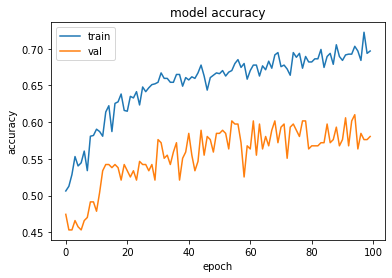

In [15]:
#summarize history for accuracy
plt.plot(history.history[(list(history.history.keys())[1])])
plt.plot(history.history[(list(history.history.keys())[3])])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

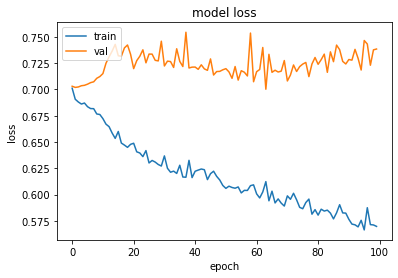

In [16]:
#summarize history for loss
plt.plot(history.history[(list(history.history.keys())[0])])
plt.plot(history.history[(list(history.history.keys())[2])])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
#generate predictions
predictions = model.predict(X_test)
print("predictions:", predictions)

predictions: [[0.44928896]
 [0.12285054]
 [0.34373957]
 [0.40874118]
 [0.09481996]
 [0.45487413]
 [0.51675105]
 [0.34750128]
 [0.79186666]
 [0.13664615]
 [0.28086048]
 [0.5468264 ]
 [0.6711968 ]
 [0.2229864 ]
 [0.2067399 ]
 [0.17122948]
 [0.17988047]
 [0.24621889]
 [0.26609296]
 [0.29870874]
 [0.77373254]
 [0.89019203]
 [0.8254789 ]
 [0.15199551]
 [0.6042824 ]
 [0.18914187]
 [0.5582658 ]
 [0.20202383]
 [0.27813172]
 [0.23553401]
 [0.8574594 ]
 [0.8114053 ]
 [0.34209156]
 [0.4125493 ]
 [0.7855984 ]
 [0.67432857]
 [0.3726589 ]
 [0.6369019 ]
 [0.44802487]
 [0.41642407]
 [0.20664343]
 [0.41021514]
 [0.2785275 ]
 [0.22852969]
 [0.63309646]
 [0.41281077]
 [0.11721581]
 [0.6404284 ]
 [0.6359123 ]
 [0.6492885 ]
 [0.66762275]
 [0.67079544]
 [0.39969105]
 [0.23979005]
 [0.66400504]
 [0.29900306]
 [0.5329141 ]
 [0.30179805]
 [0.39898622]
 [0.5832418 ]
 [0.14343336]
 [0.1742939 ]
 [0.30585253]
 [0.61364216]
 [0.600156  ]
 [0.32660085]
 [0.24272364]
 [0.29075152]
 [0.2666119 ]
 [0.15930343]
 [0.116

In [18]:
#remove encoding
real_predictions_B = a_encoder.inverse_transform(predictions)
print(real_predictions_B)

['F' 'F' 'F' 'F' 'F' 'F' 'N' 'F' 'N' 'F' 'F' 'N' 'N' 'F' 'F' 'F' 'F' 'F'
 'F' 'F' 'N' 'N' 'N' 'F' 'N' 'F' 'N' 'F' 'F' 'F' 'N' 'N' 'F' 'F' 'N' 'N'
 'F' 'N' 'F' 'F' 'F' 'F' 'F' 'F' 'N' 'F' 'F' 'N' 'N' 'N' 'N' 'N' 'F' 'F'
 'N' 'F' 'N' 'F' 'F' 'N' 'F' 'F' 'F' 'N' 'N' 'F' 'F' 'F' 'F' 'F' 'F' 'F'
 'F' 'F' 'N' 'N' 'F' 'F' 'F' 'N' 'F' 'F' 'N' 'F' 'F' 'N' 'N' 'F' 'F' 'N'
 'F' 'F' 'F' 'F' 'N' 'F' 'N' 'F' 'N' 'N' 'F' 'F' 'F' 'F' 'N' 'F' 'N' 'F'
 'F' 'F' 'F' 'N' 'F' 'F' 'N' 'N' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F'
 'N' 'N' 'N' 'F' 'F' 'F' 'N' 'N' 'F' 'F' 'N' 'F' 'F' 'F' 'F' 'F' 'N' 'F'
 'F' 'F' 'F' 'F' 'N' 'F' 'F' 'F' 'F' 'F' 'N' 'F' 'F' 'F' 'N' 'F' 'N' 'F'
 'F' 'F' 'F' 'N' 'N' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'N' 'F' 'N' 'F' 'F' 'N'
 'F' 'F' 'F' 'F' 'N' 'N' 'F' 'F' 'F' 'F' 'F' 'N' 'F' 'N' 'F' 'F' 'N' 'F'
 'F' 'F' 'F' 'N' 'F' 'N' 'N' 'F' 'F' 'F' 'N' 'F' 'F' 'N' 'F' 'F' 'N' 'N'
 'F' 'F' 'F' 'F' 'F' 'N' 'N' 'N' 'F' 'F' 'F' 'F' 'F' 'N' 'F' 'N' 'N' 'F'
 'N' 'F' 'F' 'F' 'F' 'F' 'F' 'N' 'F' 'N' 'N' 'N' 'F

In [19]:
#prediction counts
unique, counts = np.unique(real_predictions_B, return_counts=True)
dict(zip(unique, counts))

{'F': 196, 'N': 98}

In [20]:
#y_test predictions
ytest_predictions = a_encoder.inverse_transform(y_test)
print(ytest_predictions)

['N' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'N' 'F' 'F'
 'F' 'N' 'N' 'N' 'F' 'F' 'N' 'F' 'N' 'F' 'N' 'F' 'N' 'N' 'F' 'N' 'N' 'N'
 'F' 'F' 'F' 'N' 'F' 'N' 'F' 'F' 'F' 'N' 'F' 'N' 'N' 'N' 'F' 'F' 'N' 'N'
 'N' 'N' 'N' 'N' 'N' 'F' 'F' 'F' 'F' 'N' 'F' 'N' 'N' 'N' 'N' 'F' 'F' 'N'
 'F' 'N' 'F' 'N' 'N' 'N' 'F' 'N' 'F' 'F' 'N' 'N' 'N' 'F' 'N' 'F' 'N' 'N'
 'F' 'N' 'F' 'N' 'N' 'F' 'N' 'F' 'N' 'N' 'N' 'F' 'N' 'N' 'N' 'F' 'N' 'N'
 'N' 'F' 'F' 'N' 'F' 'N' 'N' 'N' 'F' 'N' 'N' 'F' 'F' 'F' 'F' 'F' 'N' 'N'
 'N' 'F' 'N' 'N' 'N' 'N' 'N' 'N' 'F' 'F' 'N' 'N' 'F' 'F' 'F' 'F' 'F' 'F'
 'F' 'F' 'F' 'F' 'N' 'F' 'F' 'F' 'F' 'F' 'N' 'N' 'F' 'F' 'N' 'F' 'N' 'N'
 'F' 'N' 'F' 'N' 'N' 'F' 'N' 'N' 'F' 'F' 'F' 'F' 'N' 'N' 'N' 'F' 'F' 'N'
 'N' 'F' 'N' 'F' 'N' 'F' 'F' 'F' 'F' 'F' 'F' 'N' 'F' 'F' 'F' 'F' 'F' 'F'
 'F' 'F' 'F' 'N' 'F' 'F' 'N' 'N' 'F' 'N' 'N' 'F' 'N' 'F' 'N' 'N' 'F' 'N'
 'N' 'N' 'N' 'F' 'N' 'N' 'N' 'N' 'N' 'F' 'N' 'F' 'N' 'F' 'F' 'N' 'N' 'F'
 'N' 'F' 'F' 'N' 'F' 'N' 'F' 'N' 'N' 'N' 'N' 'N' 'F

In [21]:
#real count
unique, counts = np.unique(ytest_predictions, return_counts=True)
dict(zip(unique, counts))

{'F': 148, 'N': 146}

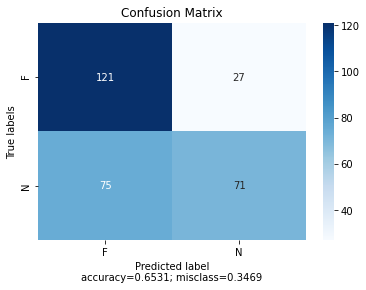

In [22]:
#confusion matrix
matrix = confusion_matrix(ytest_predictions, real_predictions_B)
#format confusion matrix
ax=plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax, cmap='Blues', fmt='g');
accuracy = np.trace(matrix) / np.sum(matrix).astype('float')
misclass = 1 - accuracy
ax.set_xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass));
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(unique); ax.yaxis.set_ticklabels(unique);

In [23]:
print(classification_report(ytest_predictions, real_predictions_B))

              precision    recall  f1-score   support

           F       0.62      0.82      0.70       148
           N       0.72      0.49      0.58       146

    accuracy                           0.65       294
   macro avg       0.67      0.65      0.64       294
weighted avg       0.67      0.65      0.64       294



In [24]:
#macro - calculate metrics for each label, and find their unweighted mean
pre_score = precision_score(ytest_predictions, real_predictions_B, average = "macro")
print('precision score:{:0.4f}'.format(pre_score))
recall_score_1 = recall_score(ytest_predictions, real_predictions_B, average= "macro")
print('recall score:{:0.4f}'.format(recall_score_1))
f1_score_1 = f1_score(ytest_predictions, real_predictions_B, average="macro")
print('f1 score:{:0.4f}'.format(f1_score_1))

precision score:0.6709
recall score:0.6519
f1 score:0.6427
